In [132]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, isnan, when
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import time

spark_session = SparkSession.builder \
    .master("spark://192.168.2.156:7077") \
    .appName("DEI.G14.Project")\
    .config("spark.dynamicAllocation.enabled", True)\
    .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
    .config("spark.shuffle.service.enabled", False)\
    .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
    .config("spark.executor.cores",4)\
    .config("spark.driver.port",9999)\
    .config("spark.blockManager.port",10005)\
    .getOrCreate()



print("Spark session started successfully!")

Spark session started successfully!


In [ ]:
file_paths = {
    #  "50k": "hdfs://192.168.2.156:9000/data/reddit/reddit_50k.json",
    # "100k": "hdfs://192.168.2.156:9000/data/reddit/reddit_100k.json",
    #  "200k": "hdfs://192.168.2.156:9000/data/reddit/reddit_200k.json",
    # "500k": "hdfs://192.168.2.156:9000/data/reddit/reddit_500k.json",
    # "1.5k": "hdfs://192.168.2.156:9000/data/G14data/redditdata_1.5k.json",
    "15k": "hdfs://192.168.2.156:9000/data/G14data/redditdata_15k.json",
    "150k": "hdfs://192.168.2.156:9000/data/G14data/redditdata_150k.json",
    "1500k": "hdfs://192.168.2.156:9000/data/G14data/redditdata_1500k.json"
}

dataset_size = "1500k"  # "15k", "150k", "1500k"
file_path = file_paths[dataset_size]

reddit_df = spark_session.read.json(file_path)

reddit_df.printSchema()

reddit_df.show(5)

root
 |-- _corrupt_record: string (nullable = true)
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- content: string (nullable = true)
 |-- content_len: long (nullable = true)
 |-- id: string (nullable = true)
 |-- normalizedBody: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- summary_len: long (nullable = true)
 |-- title: string (nullable = true)

+---------------+----------------+--------------------+--------------------+-----------+-------+--------------------+-----------+------------+--------------------+-----------+--------+
|_corrupt_record|          author|                body|             content|content_len|     id|      normalizedBody|  subreddit|subreddit_id|             summary|summary_len|   title|
+---------------+----------------+--------------------+--------------------+-----------+-------+--------------------+-----------+------------

In [ ]:
start_time = time.time()
reddit_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in reddit_df.columns]).show()

reddit_df = reddit_df.select("author", "body")

reddit_df.show(5)

user_comment_count = reddit_df.groupBy("author").agg(count("body").alias("comment_count"))

user_comment_count = user_comment_count.withColumn("comment_count", col("comment_count").cast(IntegerType()))

#print(f"Time taken to process {dataset_size} dataset: {processing_time} seconds\n")
user_comment_count.show(10)

user_comment_count_pd = user_comment_count.toPandas()

comment_counts = user_comment_count_pd['comment_count'].value_counts().sort_index()

output_file = f"result_{dataset_size}.txt"
with open(output_file, "w") as file:
    file.write(f"Results for {dataset_size} Dataset\n")
    file.write("=" * 30 + "\n")
    file.write("Comment Count\tNumber of Users\n")
    file.write("-" * 30 + "\n")
    for count, num_users in comment_counts.items():
        file.write(f"{count}\t\t{num_users}\n")
    file.write("=" * 30 + "\n")
    file.write(f"Total unique users: {len(comment_counts)}\n")
    file.write(f"Total comments: {comment_counts.sum()}\n")

end_time = time.time()

print(f"Results saved to {output_file}")
print(f'Execution time: {end_time - start_time}')


+---------------+------+----+-------+-----------+---+--------------+---------+------------+-------+-----------+------+
|_corrupt_record|author|body|content|content_len| id|normalizedBody|subreddit|subreddit_id|summary|summary_len| title|
+---------------+------+----+-------+-----------+---+--------------+---------+------------+-------+-----------+------+
|         739549|     1|   1|      1|          1|  1|             1|        1|           1|      1|          1|704184|
+---------------+------+----+-------+-----------+---+--------------+---------+------------+-------+-----------+------+

+----------------+--------------------+
|          author|                body|
+----------------+--------------------+
|raysofdarkmatter|I think it should...|
|         Stork13|Art is about the ...|
|   Cloud_dreamer|Ask me what I thi...|
|   NightlyReaper|In Mechwarrior On...|
|  NuffZetPand0ra|You are talking a...|
+----------------+--------------------+
only showing top 5 rows



+-------------+-------------+
|       author|comment_count|
+-------------+-------------+
|   laurenceks|            2|
|    Moonchill|            1|
|    UncRuckus|            2|
|   ShortWoman|           51|
| WoodenPanels|            1|
|      yrotsiH|            1|
|_NightMonkey_|            1|
|       aymbot|            1|
|  xxxamazexxx|            1|
|  LabansWidow|            1|
+-------------+-------------+
only showing top 10 rows



Results saved to result_1500k.txt
Execution time: 15.070057153701782


In [ ]:
reddit_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in reddit_df.columns]).show()

reddit_df = reddit_df.select("author", "body")

reddit_df.show(5)

[Stage 2:======================================================>  (23 + 1) / 24]

+---------------+------+----+-------+-----------+---+--------------+---------+------------+-------+-----------+------+
|_corrupt_record|author|body|content|content_len| id|normalizedBody|subreddit|subreddit_id|summary|summary_len| title|
+---------------+------+----+-------+-----------+---+--------------+---------+------------+-------+-----------+------+
|         739549|     1|   1|      1|          1|  1|             1|        1|           1|      1|          1|704184|
+---------------+------+----+-------+-----------+---+--------------+---------+------------+-------+-----------+------+

+----------------+--------------------+
|          author|                body|
+----------------+--------------------+
|raysofdarkmatter|I think it should...|
|         Stork13|Art is about the ...|
|   Cloud_dreamer|Ask me what I thi...|
|   NightlyReaper|In Mechwarrior On...|
|  NuffZetPand0ra|You are talking a...|
+----------------+--------------------+
only showing top 5 rows



In [ ]:
start_time = time.time()
user_comment_count = reddit_df.groupBy("author").agg(count("body").alias("comment_count"))

user_comment_count = user_comment_count.withColumn("comment_count", col("comment_count").cast(IntegerType()))

end_time = time.time()

processing_time = end_time - start_time
print(f"Time taken to process {dataset_size} dataset: {processing_time} seconds\n")

user_comment_count.show(10)

Time taken to process 1500k dataset: 0.026631593704223633 seconds



[Stage 6:======================================================>  (23 + 1) / 24]

+--------------------+-------------+
|              author|comment_count|
+--------------------+-------------+
|           Maxmidget|           10|
|           two-vices|            1|
|               km_nj|            1|
|            wizang30|            2|
|         CarrotSweat|            5|
|       someguyidunno|            4|
|             Zingrox|            2|
|IhaveSomeQuestions56|            3|
|         dorianfinch|            5|
|           YouDamnit|            1|
+--------------------+-------------+
only showing top 10 rows



In [ ]:
user_comment_count_pd = user_comment_count.toPandas()
start_time = time.time()

comment_counts = user_comment_count_pd['comment_count'].value_counts().sort_index()
end_time = time.time()

print(f'Execution time: {end_time - start_time}')

output_file = f"result_{dataset_size}.txt"
with open(output_file, "w") as file:
    file.write(f"Results for {dataset_size} Dataset\n")
    file.write("=" * 30 + "\n")
    file.write("Comment Count\tNumber of Users\n")
    file.write("-" * 30 + "\n")
    for count, num_users in comment_counts.items():
        file.write(f"{count}\t\t{num_users}\n")
    file.write("=" * 30 + "\n")
    file.write(f"Total unique users: {len(comment_counts)}\n")
    file.write(f"Total comments: {comment_counts.sum()}\n")

print(f"Results saved to {output_file}")

Execution time: 0.002966642379760742
Results saved to result_1500k.txt


Histogram saved to picture_15k.png


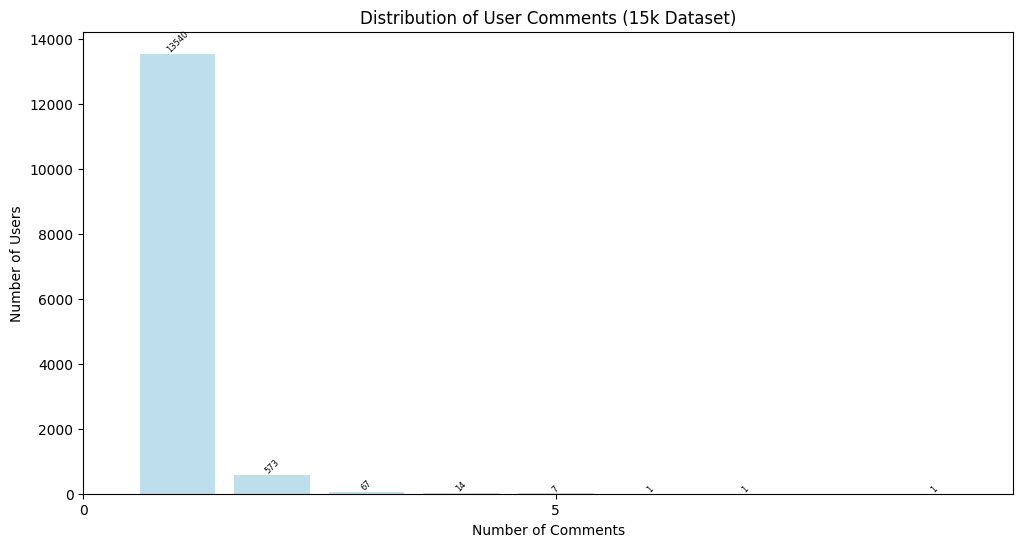

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.bar(comment_counts.index, comment_counts.values, color='lightblue', edgecolor='none', width=0.8, alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), 
             ha='center', va='bottom', fontsize=6, rotation=45)  # 字体大小改为6

plt.title(f'Distribution of User Comments ({dataset_size} Dataset)')
plt.xlabel('Number of Comments')
plt.ylabel('Number of Users')

if dataset_size not in ["500k", "1500k"]:
    plt.xticks(range(0, max(comment_counts.index) + 1, 5))

plt.grid(False)

histogram_file = f"picture_{dataset_size}.png"
plt.savefig(histogram_file, bbox_inches='tight', dpi=300)
print(f"Histogram saved to {histogram_file}")

plt.show()

In [131]:
spark_session.stop()
print(f"Spark session finished!")

Spark session finished!
